# Size Community Distribution

En nuestra etapa anterior, analizamos las métricas del grafo para comprobar \
si los grafos generados tienen propiedades de red compleja.

Una de las métricas utilizadas fue la modularidad. La métrica compara las aristas \
intra-comunidad e inter-comunidad con un modelo nulo esperado.

En este primer análisis se busca analizar la distribución del tamaño de comunidades \
con el algortimo de Louvain. De acuerdo a la literatura, muchos estudops reportan \
una distribución de cola larga. Lo anterior implica que una gran cantidad de \
comunidades pequeñas coexisten con comunidades grands.

Se tiene la hipótesis que una distribución de tamaño de comunidades que carece \
de una propiedad de cola larga carece de una estructura única o detectable de \
comunidades.

En este experimento, se análizan los cuatro datasets de control de acceso. \
Para arrojar más información a los resultados, se análiza también en los datasets \
"grandes".

In [84]:
### importar bibliotecas

import igraph as ig
import matplotlib.pyplot as plt
import numpy as np

# For degree visualization
from math import log2, ceil
from collections import Counter


In [79]:
### Auxiliar functions

def calculate_log_binning(degree_distribution, n_bins):
    """Compute the log-binning y-values in the degree distribution.

    Divides the degree distribution in `n_bins` segments.

    Parameters
    ----------
    degree_distribution: list
        Network degree distribution.
    n_bins:
        Number of bins to assign.

    Returns
    -------
    (list, list)
        The (x_values, y_values_log_bin_list) tuple.
    """
    current_sum = 0
    previous_k = 0
    y_values_log_bin_list = []
    x_values = []

    for i in range(1, n_bins):
        x_values.append(previous_k)
        current_k = 2 ** (i)
        current_sum = current_sum + current_k
        temp_y_value = sum(degree_distribution[previous_k:current_k])
        temp_y_value = temp_y_value / (current_k-previous_k)
        y_values_log_bin_list.append(temp_y_value)
        previous_k = current_k

        if current_sum > len(degree_distribution):
            x_values.append(previous_k)
            temp_y_value = sum(degree_distribution[previous_k:len(degree_distribution)])
            temp_y_value = temp_y_value / (len(degree_distribution)-previous_k)
            y_values_log_bin_list.append(temp_y_value)            
            break

    return x_values, y_values_log_bin_list

def get_path_topbot(tpe):
    """Return the paht of a type of nodes."""
    
    if tpe:
        return "01-Top"
    else:
        return "02-Bot"

def get_path_dataset(ds):
    """Return the path of a dataset ds."""

    if ds == "AMZ":
        return "01-AMZ"
    elif ds == "HC":
        return "02-HC"
    elif ds == "PM":
        return "03-PM"
    elif ds == "UN":
        return "04-UN"
    else:
        return None

In [5]:
### GLOBAL VARIABLES

DATASET = "AMZ" # AMZ, HC, PM, UN
NODE_TYPE = True

PATH_DATASET = get_path_dataset(DATASET)
PATH_NODETYPE = get_path_topbot(NODE_TYPE)

FILE_GRAPH = "../00-Data/" + PATH_DATASET + "/" + PATH_NODETYPE + "/"
FILE_GRAPH = "../00-Data/01-AMZ/02-Graphs/01-Top/AMZ_top_hyperbolic_disparity_alpha1.graphml"

In [15]:
### Read a graph

g = ig.read(FILE_GRAPH)
print(g.summary(), "\n")

print("Graph info:")
print("\t|V| =", g.vcount())
print("\t|E| =", g.ecount())
print("\t d  =", g.density())

IGRAPH U-W- 9293 3197 -- 
+ attr: id (v), weight (e) 

Graph info:
	|V| = 9293
	|E| = 3197
	 d  = 7.404700439913786e-05


In [106]:
### Compute Louvain Algorithm

comms = g.community_multilevel()
print(comms.summary(), "\n")

# ¿Cuántas comunidades tienen size de 1?
temp_var = comms.sizes().count(1)
print(
    f"Núm de comunidades con 1 elemento: {temp_var} "
    f"({temp_var*100/len(comms.sizes()):.2f}%)"
)

# Realizando un análisis de gráficar unicamente las comunidades con mas de 1.
sizes_without_one = [i for i in comms.sizes() if i > 1]
sizes_without_one = sorted(sizes_without_one, reverse=True)
print(
    f"Num de comunidades > 1: {len(sizes_without_one)}"
    f"({len(sizes_without_one)*100/len(comms.sizes()):.2f}%)"
)

# Obtener datos de la distrubución en forma de histograma
sizedistri_counts, sizedistri_bins = np.histogram(sizes_without_one,
                                                  bins=len(sizes_without_one))
print("Counts:", sizedistri_counts[:10])
print("Bins:", sizedistri_bins[:10])

Clustering with 9293 elements and 7273 clusters 

Núm de comunidades con 1 elemento: 6929 (95.27%)
Num de comunidades > 1: 344(4.73%)
Counts: [208   0  52   0  29   0  12   0   0   6]
Bins: [2.         2.43895349 2.87790698 3.31686047 3.75581395 4.19476744
 4.63372093 5.07267442 5.51162791 5.9505814 ]


<Figure size 640x480 with 0 Axes>

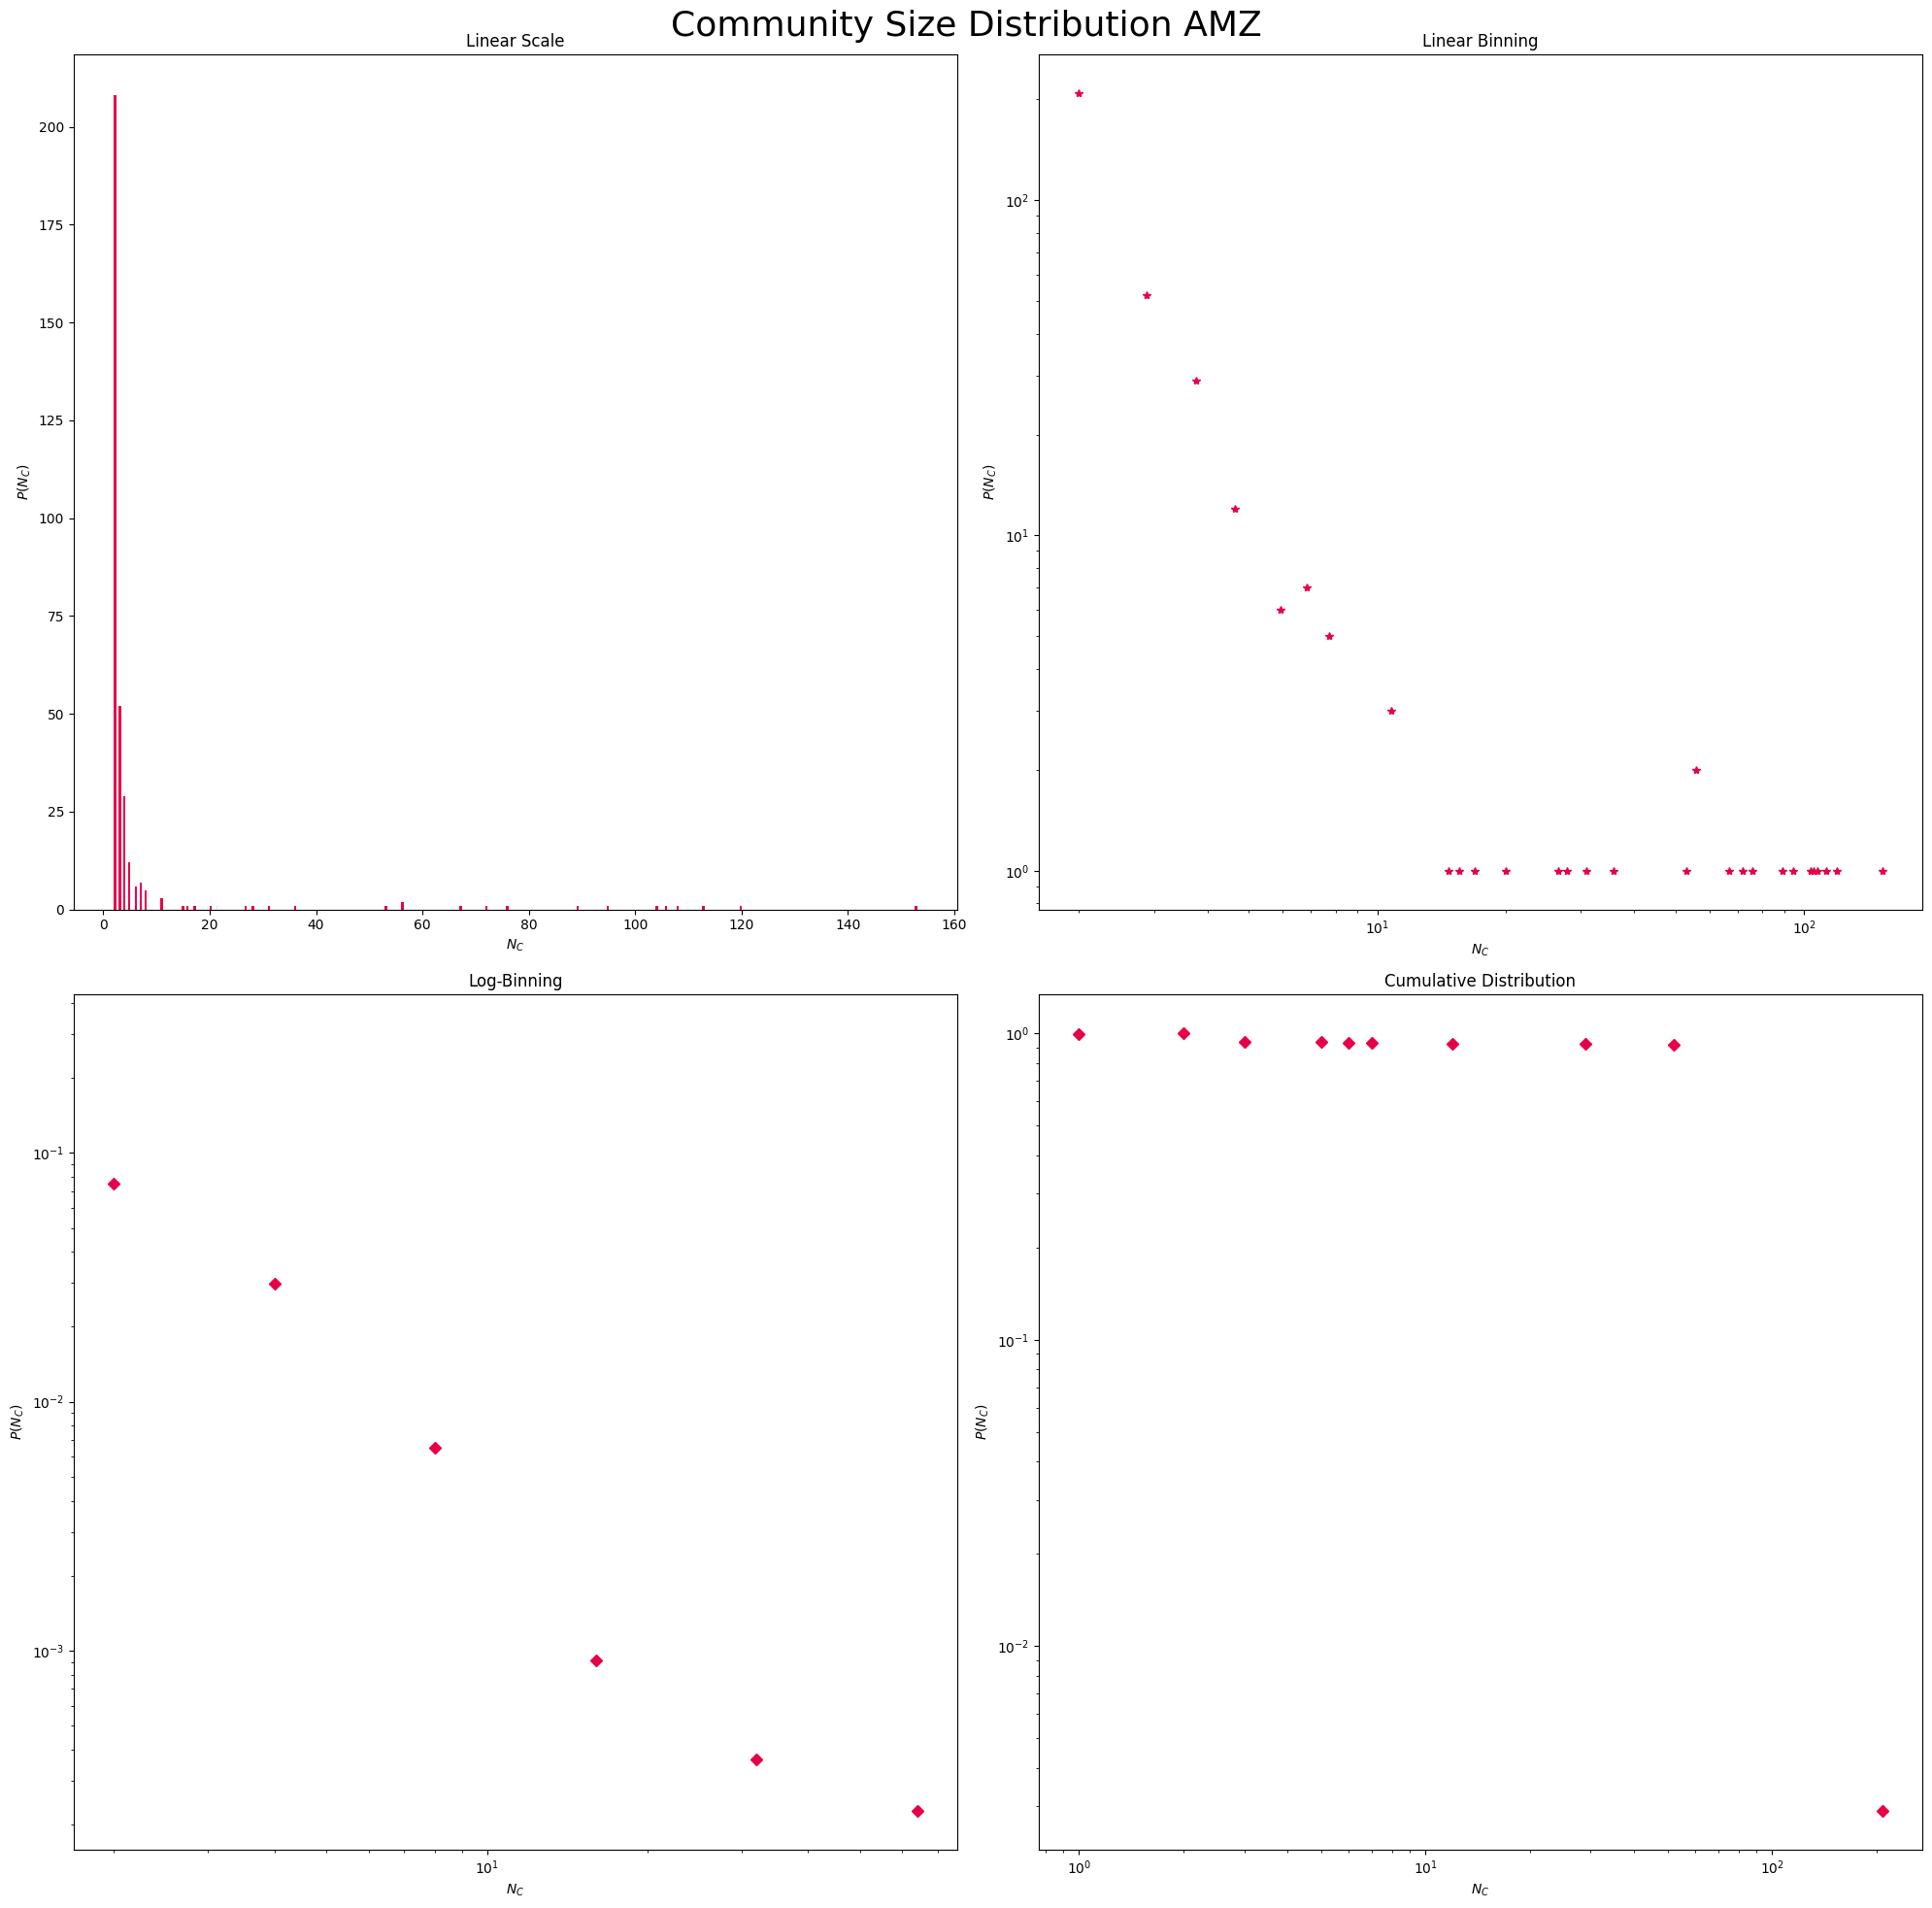

In [131]:
max_size = max(sizedistri_counts)
size_graph_data = np.array(sizedistri_counts) / len(sizedistri_counts)

plt.clf()
fig, axs = plt.subplots(2, 2, figsize=(20,20))

# LINEAR SCALE
axs[0, 0].set_title('Linear Scale')
axs[0,0 ].bar(sizedistri_bins[:-1], sizedistri_counts, color='#e60049',
              width=np.diff(sizedistri_bins), align='edge') #Replicates plt.hist
#axs[0, 0].plot(sizedistri_counts, color='#e60049', marker="D", ls='None')
axs[0, 0].set(ylabel='$P(N_C)$', xlabel='$N_C$')

# LINEAR BINNING
axs[0, 1].set_title('Linear Binning')
axs[0, 1].plot(sizedistri_bins[:-1], sizedistri_counts, color="#e60049", marker='*', ls='None')
axs[0, 1].loglog()
axs[0, 1].set(ylabel='$P(N_C)$', xlabel='$N_C$')

# LOG-BINNING
axs[1, 0].set_title('Log-Binning')
n_log_bin = ceil(log2(max_size))
x_values, y_values = calculate_log_binning(size_graph_data, n_log_bin)
axs[1, 0].plot(x_values, y_values, color='#e60049', marker="D", ls='None')
axs[1, 0].loglog()
axs[1, 0].set(ylabel='$P(N_C)$', xlabel='$N_C$')

# COMULATIVE
axs[1, 1].set_title("Cumulative Distribution")
degreeCount = Counter(sizedistri_counts)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(np.array(cnt)/len(sizedistri_counts))
axs[1, 1].loglog(deg, cs, color='#e60049', marker="D", ls='None')
axs[1, 1].set(ylabel='$P(N_C)$', xlabel='$N_C$')

fig.suptitle("Community Size Distribution "+DATASET, fontsize=26)
fig.tight_layout()
plt.show()